In [1]:
import numpy as np
from scipy import signal
import seaborn as sns
import scipy.stats as stats
from scipy.ndimage.interpolation import shift
import scipy.interpolate as interpolate
import itertools as it
import pandas as pd
import pickle
import math
import matplotlib.pyplot as plt
from lab.classes.dbclasses import dbMouse
from lab.analysis import behavior_analysis as ba
from lab.misc.auto_helpers import locate
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

In [2]:
%run Helper_Functions.ipynb

In [ ]:
dataBuffer = []
for mousename in ['BV160', 'BV163', 'BV165', 'BV167', 'BV169', 'TG531', 'TG532', 'TG535']:
    exptListAll = [expt for expt in dbMouse(mousename).imagingExperiments() if \
                   (expt.experimentType == 'PreGOL') or (expt.experimentType == 'GOL') or \
                  (expt.experimentType == 'PostGOL')]
    
    print(str(len(exptListAll)) + ' experiments:')
    count = 0
    for expt in exptListAll:
        print(str(count)+ ', ' ),
        count = count + 1

        if expt.experimentType == 'GOL':
            try:
                delta_anticip_licks = get_delta_anticipatory_licks(expt)
            except:
                delta_anticip_licks = np.nan
            dataBuffer.append({'mouse': mousename,
                'session': expt.session,
                'laps': expt.laps,
                'day': expt.day,   
                'startTime': expt.startTime(),
                'exptType': expt.experimentType,               
                'Delta_Anticip_Licks': delta_anticip_licks})   
        else:
            ripple_frames = loadRippleFrames(expt)
            n_ripples = len(ripple_frames)
                
            filepath = expt.LFPFilePath() + '/Ripple_Properties.pkl'
            with open(filepath, 'rb') as f:
                data = pickle.load(f)
            durations = data['ripple_durations']
            
            if n_ripples > 0:
                fraction_long_duration_ripples = len(np.where(np.asarray(durations) > 0.1)[0]) / \
                                                float(len(ripple_frames))
            else:
                fraction_long_duration_ripples = np.nan
                
            dataBuffer.append({'mouse': mousename,
                'session': expt.session,
                'day': expt.day,      
                'startTime': expt.startTime(),              
                'exptType': expt.experimentType,               
                'n_ripples': len(ripple_frames),
                'durations': durations, 
                'fraction_long_duration_SWRs': fraction_long_duration_ripples})   
    
dataBuffer = pd.DataFrame(dataBuffer)

In [5]:
GOL_Days = [0, 1, 2, 3, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 0, 1, 2, 3, 0, 1, 2, \
           3, 4, 0, 1, 2, 3, 4, 5, 6, 7]

In [6]:
summary_data['GOL_Days'] = GOL_Days

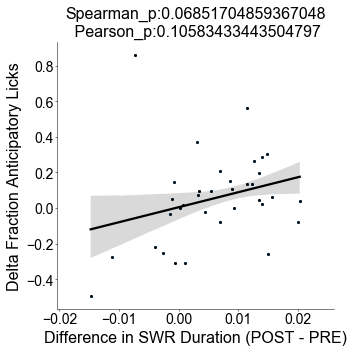

In [10]:
fig, ax = plt.subplots(1,1,figsize = (5,5))
ax.scatter(summary_data.Delta_Durations, summary_data.Delta_Anticip_Licks)
sns.regplot(summary_data.Delta_Durations, summary_data.Delta_Anticip_Licks, \
            ci = 68, color = 'black', ax = ax)
ax.tick_params(axis = 'x', labelsize = 14)
ax.tick_params(axis = 'y', labelsize = 14)
ax.set_xlabel('Difference in SWR Duration (POST - PRE)', fontsize = 16)
ax.set_ylabel('Delta Fraction Anticipatory Licks', fontsize = 16)
ax.set_title('Spearman_p:' + str(stats.spearmanr(summary_data.Delta_Durations, \
            summary_data.Delta_Anticip_Licks)[1]) + '\n Pearson_p:' + \
            str(stats.pearsonr(summary_data.Delta_Durations, summary_data.Delta_Anticip_Licks)[1]), \
            fontsize = 16)
#ax.axhline(y = 0)
simpleaxis(ax)

fig.tight_layout()
plt.savefig('Delta_Durations_vs_Delta_Anticip_Licks_Scatter.svg', format = 'svg', \
            dpi = 1200, transparent = True)

In [11]:
new_data = pd.DataFrame(data = summary_data, columns = ['Learning_Type', 'Post_Durations', \
                                                        'Pre_Durations'])
new_data = pd.melt(new_data, id_vars = 'Learning_Type')
index = np.tile(range(len(new_data.Learning_Type)/2),2)
new_data['Index'] = index

/home/bert/.local/lib/python2.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/bert/.local/lib/python2.7/site-packages/ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


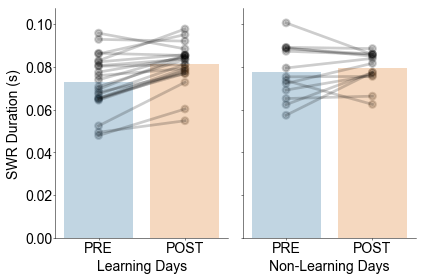

In [12]:
fig, ax = plt.subplots(1, 2, figsize = (6,4), sharey = True)
order = ['Pre_Durations', 'Post_Durations']
sns.barplot(x = 'variable', y = 'value', data = new_data[new_data.Learning_Type == 'Learning'], \
            alpha = 0.3, order = order, ci = 68, ax = ax[0])

for i in new_data[new_data.Learning_Type == 'Learning'].Index:
    g = sns.pointplot(x = 'variable', y = 'value', \
                    data = new_data[new_data.Learning_Type == 'Learning'][new_data.Index == i], \
                    color = 'black', order = order, ax = ax[0])
plt.setp(g.collections, alpha=.1) #for the markers
plt.setp(g.lines, alpha=.1)       #for the lines   

ax[0].set_xlabel('Learning Days', fontsize = 14)
ax[0].set_ylabel('SWR Duration (s)', fontsize = 14)
ax[0].set_xticklabels(['PRE', 'POST'], fontsize = 14)
ax[0].tick_params(axis = 'x', labelsize = 14)
ax[0].tick_params(axis = 'y', labelsize = 14)
simpleaxis(ax[0])

sns.barplot(x = 'variable', y = 'value', \
            data = new_data[new_data.Learning_Type == 'Non_Learning'], alpha = 0.3, ci = 68, \
            order = order, ax = ax[1])

for j in new_data[new_data.Learning_Type == 'Non_Learning'].Index:
    k = sns.pointplot(x = 'variable', y = 'value', \
                    data = new_data[new_data.Learning_Type == 'Non_Learning'][new_data.Index == j],\
                    color = 'black', order = order, ax = ax[1])
plt.setp(k.collections, alpha=.1) #for the markers
plt.setp(k.lines, alpha=.1)       #for the lines   
    
ax[1].set_xlabel('Non-Learning Days', fontsize = 14)
ax[1].set_ylabel('')
ax[1].set_xticklabels(['PRE', 'POST'], fontsize = 14)
ax[1].tick_params(axis = 'x', labelsize = 14)
ax[1].tick_params(axis = 'y', labelsize = 14)
simpleaxis(ax[1])

fig.tight_layout()
plt.savefig('SWR_Durations_Learning_vs_Non_Learning.svg', format = 'svg', \
            dpi = 1200, transparent = True)